In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

load_dotenv(find_dotenv())

# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("erdatabase"),
                                user=os.environ.get("eruser"),
                                password = os.environ.get("erpassword"),
                                host=os.environ.get("erhost"),
                                port=os.environ.get("erport"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [2]:
def pgquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        conn.close()
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
        conn.close()

In [21]:
# This function will return a reshaped dataframe that contains the following columns:
#
# incident_id | responderunit_id | responder_id | typenaturecode_id | fireblock | t1 | t2 |  ...
# where t1, t2, ... , tn are the timedesc_id that we are looking for.
#
# usage: getTimeDataset(timedesc_dict)
#
# param: timedesc_dict - keys are the timedesc_ids you want
#                      - values are the human descriptions for them 
# known issues: this eliminates "responder_id" (so we can probably just get rid of it in the query)
#               responder_id values were inconsistent and strange, so I decided to just ignore them
#               when doing anaylsis.
def getTimeDataset(timedesc_dict):
    RESPONSE_TIME_QUERY='''
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN ??TIMEDESC_IDS??
                                AND T.responder_id IS NOT NULL;
                        '''
    
    # add the timedesc_ids that we want to the query
    timedesc_ids = str(tuple(timedesc_dict.keys())).replace("'", "")
    RESPONSE_TIME_QUERY = RESPONSE_TIME_QUERY.replace("??TIMEDESC_IDS??", str(timedesc_ids))
    
    # execute the query: **this takes a pretty long time**
    df = pgquery(RESPONSE_TIME_QUERY)
    
    # now reshape the data so that we can do analysis more easily. 
    table = df.pivot_table(index=['incident_id', 'responderunit_id', 'typenaturecode_id',
                                  'fireblock', 'fmarespcomp'],
                      columns='timedesc_id', values='realtime', aggfunc='first')
    table.rename(columns=timedesc_dict, inplace=True)
    
    return table

##### We are interested in calculating Response Time, which is the time it takes from 'Dispatch' to 'On Scene' for the firefighters.

In [38]:
d = {3 : 'Dispatched', 5 : 'On Scene'}
table = getTimeDataset(d)

Opened database successfully
SQL QUERY = 
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN (3, 5)
                                AND T.responder_id IS NOT NULL;
                        


In [39]:
# take a look at the results.
table.head(20)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   
            218.0            141.0             0133      01          2010-01-01 00:21:17   
            230.0            141.0             0133      01          2010-01-01 00:23:33   
754227      30.0             141.0             0109      01          2010-01-01 00:09:02   
            215.0            141.0             0109      01          2010-01-01 00:09:02   
754228      33.0             12.0              0127      01          2010-01-01 00:17:31   
            116.0            12.0              0127      01          2010-01-01 00:17:31   
754229      46.0             147.0             2530      25          2010-01-01 00:19:21   
            218.0            147.0             2530      25          2010-01-01 00:21:26   
            230.0            147.0             2530      25          2010-01-01 00:19:21   
754230      116.0            155.0             0127      01          2010-01-01 00:25:34   

timedesc_id                                                                     On Scene  
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                      
754221      52.0             147.0             0375      03                          NaT  
            221.0            147.0             0375      03          2010-01-01 00:09:53  
754222      58.0             134.0             0727      07          2010-01-01 00:08:57  
            218.0            134.0             0727      07          2010-01-01 00:07:14  
754224      232.0            21.0              1109      11          2010-01-01 00:17:01  
            415.0            21.0              1109      11          2010-01-01 00:17:36  
754225      120.0            125.0             2530      25                          NaT  
            229.0            125.0             2530      25          2010-01-01 00:26:53  
754226      56.0             141.0             0133      01          2010-01-01 00:27:50  
            123.0            141.0             0133      01          2010-01-01 00:22:56  
            218.0            141.0             0133      01                          NaT  
            230.0            141.0             0133      01          2010-01-01 00:30:27  
754227      30.0             141.0             0109      01          2010-01-01 00:17:39  
            215.0            141.0             0109      01          2010-01-01 00:19:38  
754228      33.0             12.0              0127      01                          NaT  
            116.0            12.0              0127      01          2010-01-01 00:23:24  
754229      46.0             147.0             2530      25          2010-01-01 00:25:06  
            218.0            147.0             2530      25                          NaT  
            230.0            147.0             2530      25                          NaT  
754230      116.0            155.0             0127      01     

In [40]:
table["difference"] = table['On Scene'].sub(table['Dispatched'], axis = 0)
table["difference"].astype('timedelta64[s]')
table.head(20)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   
            218.0            141.0             0133      01          2010-01-01 00:21:17   
            230.0            141.0             0133      01          2010-01-01 00:23:33   
754227      30.0             141.0             0109      01          2010-01-01 00:09:02   
            215.0            141.0             0109      01          2010-01-01 00:09:02   
754228      33.0             12.0              0127      01          2010-01-01 00:17:31   
            116.0            12.0              0127      01          2010-01-01 00:17:31   
754229      46.0             147.0             2530      25          2010-01-01 00:19:21   
            218.0            147.0             2530      25          2010-01-01 00:21:26   
            230.0            147.0             2530      25          2010-01-01 00:19:21   
754230      116.0            155.0             0127      01          2010-01-01 00:25:34   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   
            218.0            141.0             0133      01                          NaT   
            230.0            141.0             0133      01          2010-01-01 00:30:27   
754227      30.0             141.0             0109      01          2010-01-01 00:17:39   
            215.0            141.0             0109      01          2010-01-01 00:19:38   
754228      33.0             12.0              0127      01                          NaT   
            116.0            12.0              0127      01          2010-01-01 00:23:24   
754229      46.0             147.0             2530      25          2010-01-01 00:25:06   
            218.0            147.0             2530      25                          NaT   
            230.0            147.0             2530      25                          NaT   
754230      116.0            155.0         

In [41]:
table["diff_min"] = (table["difference"] / pd.Timedelta(minutes=1, seconds=0))
table.head(10)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   

timedesc_id                                                           difference  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp               
754221      52.0             147.0             0375      03                  NaT   
            221.0            147.0             0375      03             00:02:21   
754222      58.0             134.0             0727      07             00:04:33   
            218.0            134.0             0727      07             00:02:50   
754224      232.0            21.0              1109      11             00:02:46   
            415.0            21.0              1109      11             00:03:21   
754225      120.0            125.0             2530      25                  NaT   
            229.0            125.0             2530      25             00:10:32   
754226      56.0             141.0             0133      01             00:06:33   
            123.0            141.0             0133      01             00:00:45   

timedesc_id                                                            diff_min  
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp             
754221      52.0             147.0             0375      03                 NaN  
            221.0            147.0             0375      03            2.350000  
754222      58.0             134.0             0727      07            4.550000  
            218.0            134.0             0727      07            2.833333  
754224      232.0            21.0              1109      11            2.766667  
            415.0            21.0              1109      11            3.350000  
754225      120.0            125.0             2530      25                 NaN  
            229.0            125.0         

In [42]:
table.describe()

timedesc_id,difference,diff_min
count,889921,8.899210e+05
mean,-1 days +23:38:10.949737,-2.181750e+01
std,17 days 01:23:53.266197,2.456389e+04
min,-16071 days +00:03:54,-2.314224e+07
25%,0 days 00:03:58,3.966667e+00
50%,0 days 00:05:10,5.166667e+00
75%,0 days 00:06:38,6.633333e+00
max,70 days 06:14:30,1.011745e+05


#### Hmm.. It is interesting that we have negative time differences.. let's investigate those.

In [43]:
neg = table.loc[table['diff_min'] < 0.0]
neg.shape

(196, 4)

#### Ok, so there are only a few rows with negative values (a couple hundred out of about a million rows). Let's just ignore those for now, and possibly look into them later.

In [28]:
# keep only the response times from 0 minutes to a day
table = table.loc[table['diff_min'] >= 0.0].loc[table['diff_min'] <= 1440] # less than a day

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


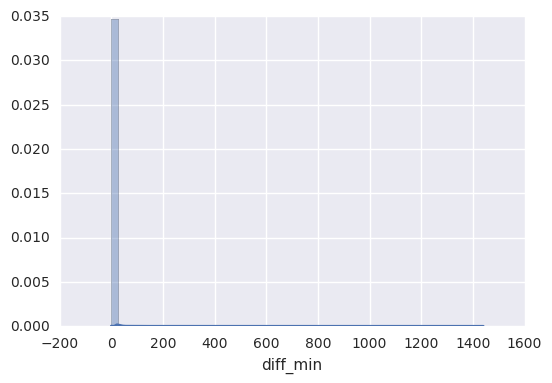

In [29]:
sns.distplot(table['diff_min'])

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


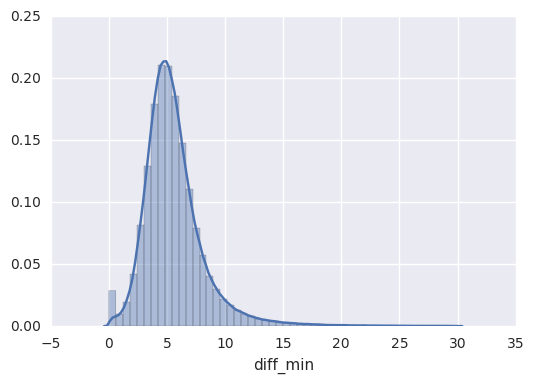

In [30]:
sns.distplot(table.loc[table['diff_min'] <= 30]['diff_min']) # zoomed in on thirty minutes

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


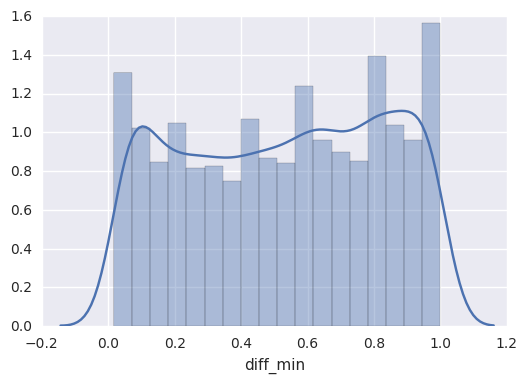

In [31]:
sns.distplot(table.loc[table['diff_min'] > 0.0].loc[table['diff_min'] <= 1]['diff_min'])

**Thoughts:**

Looks like there are a lot of zero response time incidents. Which is strange. I think we should do some further insight into why these exist and then determine if we should include them in the analysis. 

The data could fit a geometric or weibull distribution? We can look into this to find out what the average
response times are (rather than using mean).

**Things to do:**
- Ignore fire teams that create incident reports, since they are not responders.
- Find the average response times given a type of incident.
- See if there is a good way to categorize all these incident codes.
- Find the average response times for each of the fireblocks. 
- Generalize these methods so that we can gain this information by specific Datetime information.

In [49]:
table['fmarespcomp'] = table.index.get_level_values('fmarespcomp') 
fmaResponseTimes = table.groupby(['fmarespcomp'])['diff_min'].median()
fmaResponseTimes.head(40)

fmarespcomp
0              NaN
01        4.616667
02        5.766667
03        4.866667
04        4.633333
05        6.133333
06        5.808333
07        5.066667
08        4.533333
09        5.100000
1        30.916667
10        6.433333
11        4.883333
12        4.916667
13        4.916667
14        5.566667
15        6.400000
16        6.916667
17        6.916667
18        6.350000
19        4.950000
20        6.383333
21        4.833333
210       8.283333
22        5.566667
23        5.966667
24        4.933333
25        5.333333
26        5.066667
27        9.016667
28        5.116667
29        5.933333
30        5.300000
31        5.233333
32       13.483333
61       11.416667
62        4.583333
62551     4.950000
71        5.300000
72        5.816667
Name: diff_min, dtype: float64

In [50]:
fmaResponseTimes.shape

(59,)

In [53]:
fmaCounts = table.groupby(['fmarespcomp'])['diff_min'].count()
fmaCounts.head(40)

fmarespcomp
0            0
01       73708
02       22142
03       50967
04       48817
05       13166
06        3910
07       74873
08       22141
09       28085
1            1
10        5975
11       51780
12       27689
13       50049
14       32134
15        3875
16        7784
17       13450
18       20901
19       37253
20       17031
21       21239
210        234
22       23935
23       11880
24       25029
25       38833
26       20130
27        2370
28       26079
29       25167
30       36943
31       42741
32          83
61          31
62           4
62551        1
71        1012
72         424
Name: diff_min, dtype: int64

## Everything below is preliminary work. It is kept for reference.

The below query is used to get response time metrics. First, notice that we select only time description id's that correspond to dispatched and onscene times. Next, we are ignoring rows where responder_id is null. This is because we don't care about BOEC times. Instead, we are only focused on response times for actual units. 


NOTE TO SELF: WE MAY WANT TO REMOVE THE RESPONDER_ID FIELD, BECAUSE IT IS CONFUSING AS HELL LOL.

RESPONSE_TIME_QUERY='''
SELECT  I.incident_id, R.responderunit_id, T.responder_id,
        T.timedesc_id, I.typenaturecode_id, I.fireblock, T.realtime
FROM incident as I
INNER JOIN inctimes as T
        ON I.incident_id = T.incident_id
INNER JOIN responder as R
        ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
WHERE T.timedesc_id IN (3, 5)
        AND T.responder_id IS NOT NULL;
'''

df = pgquery(RESPONSE_TIME_QUERY)

df.shape